### Import Libraries and Data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings


warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [2]:
# Configure API key
quandl.ApiConfig.api_key = 'Zhv1MKMFgFbxUx9fv4qY'

In [3]:
# Importing the Federal Reserve Economic Data\ Civilian Unemployment Rate
data = quandl.get('FRED/UNRATE')

In [4]:
# Checking the head
data.head(5)

,Value
Date,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5


In [5]:
data.shape

(889, 1)

In [6]:
data.columns

Index(['Value'], dtype='object')

In [7]:
type(data) # This may not be important to copy to Final draft

pandas.core.frame.DataFrame

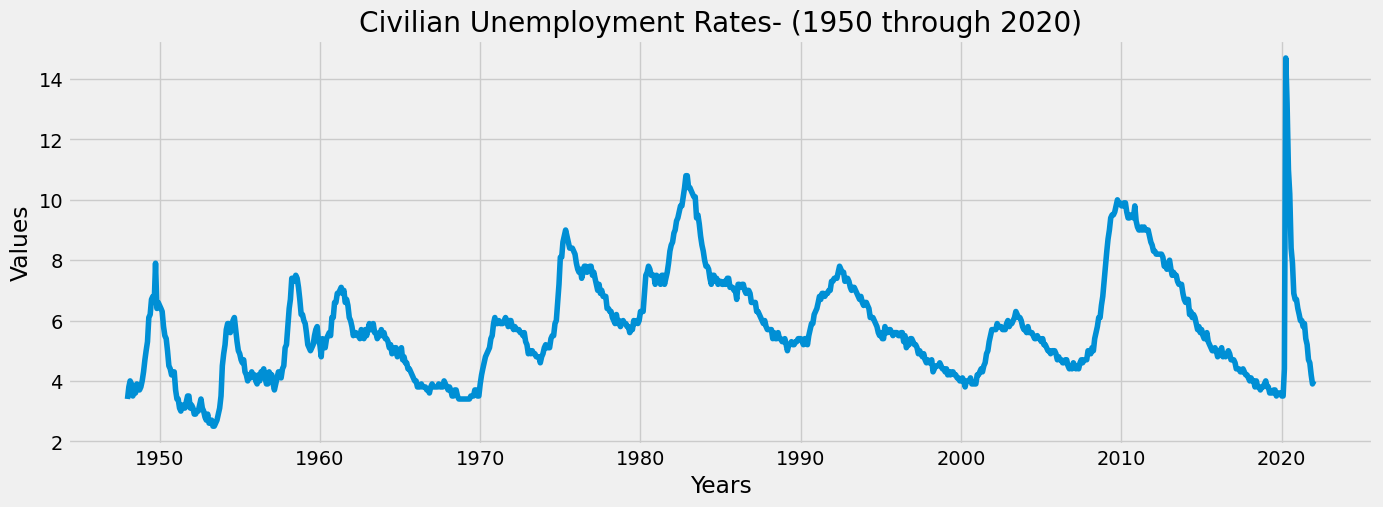

In [42]:
# Plot the data using matplotlib
plt.figure(figsize=(15,5), dpi=100)
plt.title('Civilian Unemployment Rates- (1950 through 2020)'),
plt.xlabel('Years'),
plt.ylabel('Values'),
plt.plot(data)

### 2. Subsetting, wrangling, and cleaning time-series data

In [9]:
# Resetting index to use Date column as a filter
data_2 = data.reset_index()

In [10]:
data_2.head()

,Date,Value
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5


In [11]:
# Subsetting df
data_sub = data_2.loc[(data_2['Date'] >= '2010-01-01') & (data_2['Date'] < '2020-06-01')]

###    I didn't find a data set that correlated with my final project "Flavors of Cacoa", so I opted to do my time series over a dataset that sparked my interest: "the unemployment rate" amongst civilians over the last ten years (2010- 2020). This analysis will show patterns or trends to help pinpoint a possible cause of the unemployment rate spike(s). 

In [12]:
# Checking shape of subset
data_sub.shape

(125, 2)

In [13]:
data_sub.head()

,Date,Value
744,2010-01-01,9.8
745,2010-02-01,9.8
746,2010-03-01,9.9
747,2010-04-01,9.9
748,2010-05-01,9.6


In [14]:
# Setting Date column as the Index and creating a datetime column 
data_sub['datetime'] = pd.to_datetime(data_sub['Date'])

# Now setting the datetime as the index of the df
data_sub = data_sub.set_index('datetime')

# Lastly, dropping the date column
data_sub.drop(['Date'], axis=1, inplace=True)

In [15]:
# Checking the head after making changes
data_sub.head()

,Value
datetime,
2010-01-01,9.8
2010-02-01,9.8
2010-03-01,9.9
2010-04-01,9.9
2010-05-01,9.6


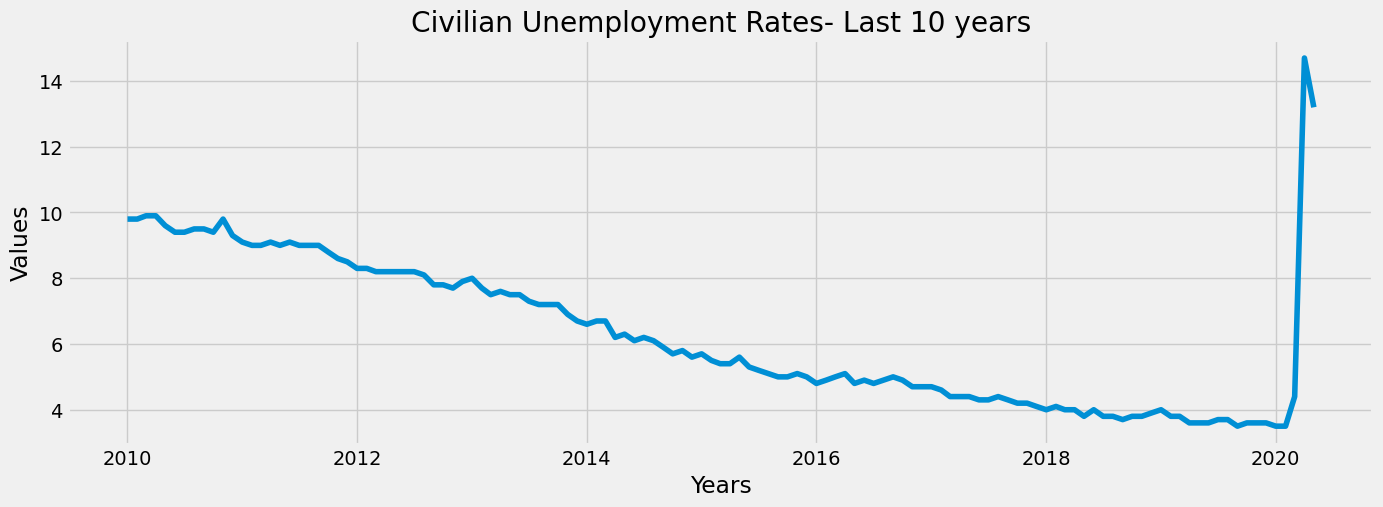

In [37]:
# Plot the new data set
plt.figure(figsize=(15,5), dpi=100)
plt.title('Civilian Unemployment Rates- Last 10 years'),
plt.xlabel('Years'),
plt.ylabel('Values'),
plt.plot(data_sub)


### Cleaning Time Series Data ##### Before Decomposing

In [17]:
# Checking for missing values
data_sub.isnull().sum()

Value    0
dtype: int64

In [18]:
# Check for duplicates
dups = data_sub.duplicated()

In [19]:
dups.sum()

71

In [20]:
dups

datetime
2010-01-01    False
2010-02-01     True
2010-03-01    False
2010-04-01     True
2010-05-01    False
              ...  
2020-01-01     True
2020-02-01     True
2020-03-01     True
2020-04-01    False
2020-05-01    False
Length: 125, dtype: bool

#### Not addressing dups. ##  Not true duplicates- not removing.  Month and day repeats itself yearly.

### 3. Time-series analysis: decomposition

In [21]:
# Decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [22]:
# Define a fixed size for all special charts.
from pylab import rcParams 

In [23]:
rcParams['figure.figsize'] = 18, 7

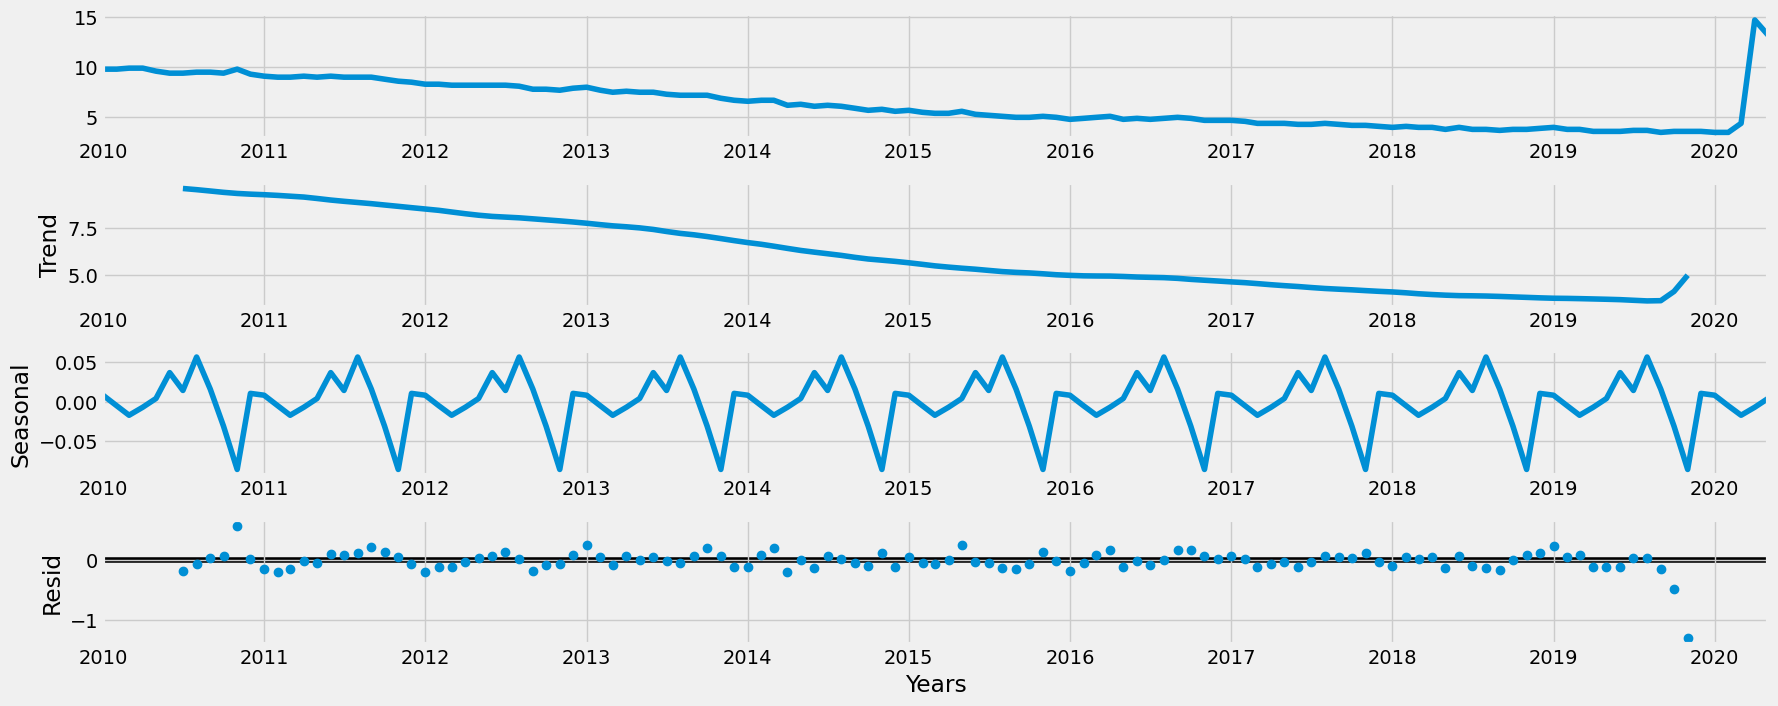

In [39]:
# Plot the separate components
decomposition.plot(),
plt.xlabel('Years'),
# Show the plot
plt.show()

### Analyzing the data:

#### Trend line: After 2010, the trend line is downward, showing a gradual decrease in the unemployment rate, with a spike in 2020 due to the COVID-19 pandemic of 2020-21.

#### Seasonality line: displays spikey curves throughout 2010-2020, demonstrating some form of seasonality. We can surmise that the spikes are during the holiday season (Christmas).

#### Residual line: doesn’t appear to show much noise. However, the data points start to trail off around 2020, which is unsurprising.

### 4. Testing for stationarity

In [25]:
# Import adfuller function
from statsmodels.tsa.stattools import adfuller

In [26]:
# Define the function
def dickey_fuller(timeseries):
    # Perform the Dickey-Fuller test:
    print('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key, value in test[4].items():
        result['Critical Value (%s)' % key] = value
    print(result)

In [27]:
# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -1.644966
p-value                          0.459667
Number of Lags Used              0.000000
Number of Observations Used    124.000000
Critical Value (1%)             -3.484220
Critical Value (5%)             -2.885145
Critical Value (10%)            -2.579359
dtype: float64


#### In reviewing the test results, my test statistics of -1.644966 is more significant than all of the critical values, implying that my series is non-stationary. Therefore, I must apply further differentiation to reject the hypothesis that the unemployment rate(s) fluctuates significantly yearly.

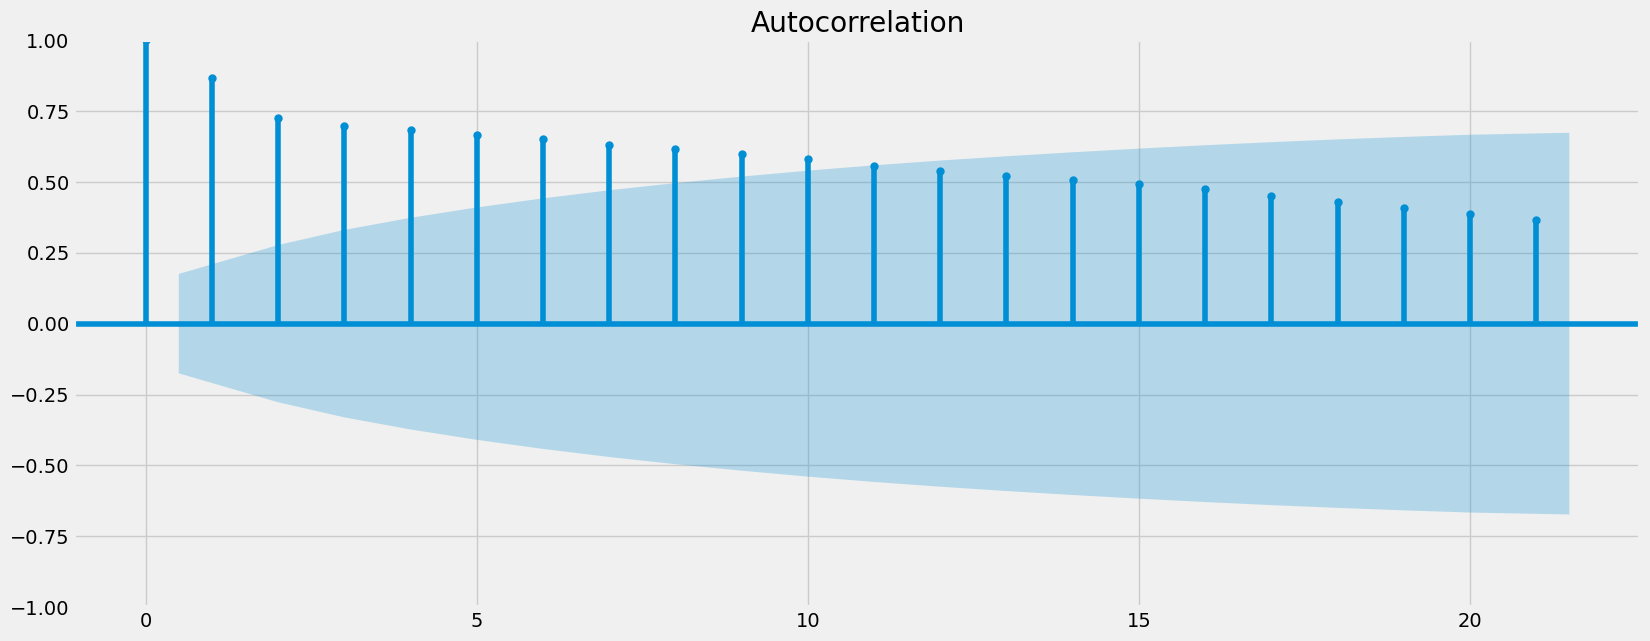

In [28]:
# Import the autocorrelation and partial correlation and #Check out a plot of autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data_sub)
plt.show()

### 5. Stationarizing the Data

In [29]:
# Using the df.shift() function
data_diff = data_sub - data_sub.shift(1)

In [30]:
data_diff.dropna(inplace = True)

In [31]:
data_diff.head()

,Value
datetime,
2010-02-01,0.0
2010-03-01,0.1
2010-04-01,0.0
2010-05-01,-0.3
2010-06-01,-0.2


In [32]:
data_diff.columns

Index(['Value'], dtype='object')

Text(0, 0.5, 'Values')

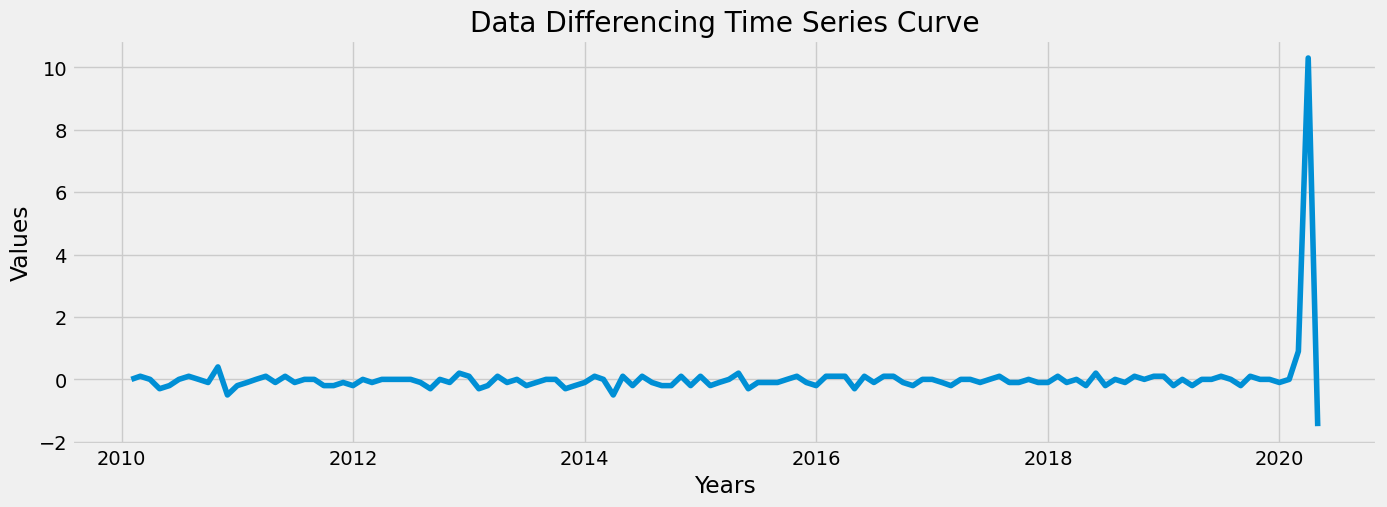

In [41]:
# Check out what the differencing did to the time-series curve
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)
# Add an axis labels
plt.title('Data Differencing Time Series Curve'),
plt.xlabel('Years'),
plt.ylabel('Values')

In [34]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.154772e+01
p-value                        3.507950e-21
Number of Lags Used            0.000000e+00
Number of Observations Used    1.230000e+02
Critical Value (1%)           -3.484667e+00
Critical Value (5%)           -2.885340e+00
Critical Value (10%)          -2.579463e+00
dtype: float64


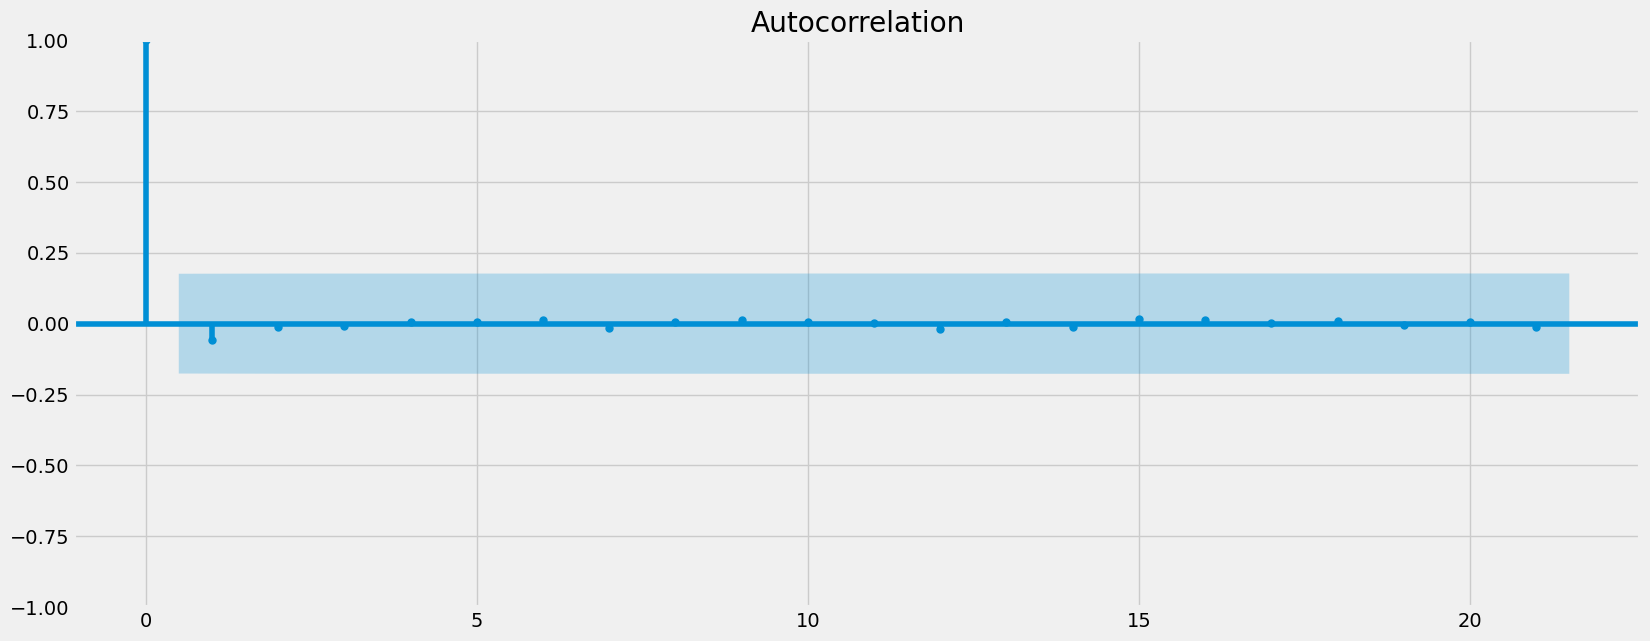

In [35]:
# Checking Autocorrelation
plot_acf(data_diff)
plt.show()